### import modules

In [1]:
import cv2
import glob
import copy
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [66]:
def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPool1D, GlobalAveragePooling1D
from keras.layers import Convolution2D, MaxPool2D
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils import np_utils

### input data

In [3]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')
train = train_data[['id', 'species']]
test = test_data[['id']]

### データの前処理

In [8]:
def resize_img_2d(img=np.array([]), end_size=100, show=False):
    max_ = np.maximum(img.shape[0], img.shape[1])
    scale = end_size / max_
    height, width = img.shape
    size = (int(width * scale), int(height * scale))

    rescale_img = cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)
    height, width = rescale_img.shape

    if width > height:
        z_padding = np.zeros([int((width - height) / 2), width], dtype=np.uint8)
        resize_img = np.vstack((z_padding, rescale_img, z_padding))
    else:
        z_padding = np.zeros([height, int((height - width) / 2)], dtype=np.uint8)
        resize_img = np.hstack((z_padding, rescale_img, z_padding))

    resize_img = cv2.resize(resize_img, (end_size, end_size))
    resize_img2 = resize_img.reshape(-1,)

    if show == True: return resize_img
    else:

        return resize_img

In [9]:
# label_speacies の作成
all_label_list = train['species'].values
i = 0
label_species = {}
for label in all_label_list:
    if label in label_species: pass
    else:
        label_species['{}'.format(label)] = i
        i = i + 1
# label_species

In [12]:
end_size = 100
# x_train の作成
x_train = []
for _id in train['id']:
    img = np.array(Image.open('../input/images/{:.0f}.jpg'.format(_id)))
    x_train.append(resize_img_2d(img, end_size=end_size))
x_train = np.array(x_train)

In [14]:
# x_test の作成
x_test = []
for _id in test['id']:
    img = np.array(Image.open('../input/images/{:.0f}.jpg'.format(_id)))
    x_test.append(resize_img_2d(img, end_size=end_size))
x_test = np.array(x_test)

In [15]:
# t_train の作成
t_train = []
for _species in train['species']:
    _t_train = np.array([0] * 99)
    correct_label = label_species[_species]
    _t_train[correct_label] = 1
    t_train.append(_t_train)
t_train = np.array(t_train)

In [55]:
print('x_train', x_train.shape)
print('x_test', x_test.shape)
print('t_train', t_train.shape)
x_train_r = np.zeros((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_train_r[:, :, :, 0] = x_train
x_test_r = np.zeros((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_test_r[:, :, :, 0] = x_test
print('x_train_r', x_train_r.shape)
print('x_test_r', x_test_r.shape)

x_train (990, 100, 100)
x_test (594, 100, 100)
t_train (990, 99)
x_train_r (990, 100, 100, 1)
x_test_r (594, 100, 100, 1)


In [41]:
label_encoder = LabelEncoder().fit(train.species)
labels = label_encoder.transform(train.species)
classes = list(label_encoder.classes_)
nb_classes = len(classes)

### Cross validation (とりあえずやらん)

In [62]:
# sss = StratifiedShuffleSplit(test_size=0.1, random_state=23)
# for train_index, valid_index in sss.split(scaled_train, labels):
#     X_train, X_valid = scaled_train[train_index], scaled_train[valid_index]
#     y_train, y_valid = labels[train_index], labels[valid_index]
y_train = labels
y_train = np_utils.to_categorical(y_train, nb_class)
print('y_train', y_train.shape)

y_train (990, 99)


### Conv2D の作成

In [67]:
model = Sequential()

model.add(Convolution2D(64, 3 , input_shape = (end_size, end_size , 1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(32,3))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes, activation='softmax'))

adam = Adam(lr=1e-4)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

W0828 09:54:25.083967 4502771136 deprecation.py:506] From /Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [39]:
# sgd = SGD(lr=0.1, nesterov=True, decay=1e-6, momentum=0.9)
# model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

### 学習

In [70]:
nb_epoch = 100
model.fit(x_train_r, y_train, nb_epoch=nb_epoch, batch_size=16, validation_split=0.1)

Train on 891 samples, validate on 99 samples
Epoch 1/100
891/891 [==============================] - 20s 23ms/step - loss: 9.3687 - acc: 0.1481 - val_loss: 4.0012 - val_acc: 0.2020
Epoch 2/100
891/891 [==============================] - 26s 29ms/step - loss: 2.8172 - acc: 0.3939 - val_loss: 2.3515 - val_acc: 0.4040
Epoch 3/100
891/891 [==============================] - 21s 23ms/step - loss: 1.0591 - acc: 0.7205 - val_loss: 1.7822 - val_acc: 0.5152
Epoch 4/100
891/891 [==============================] - 19s 22ms/step - loss: 0.4550 - acc: 0.8709 - val_loss: 1.6718 - val_acc: 0.5657
Epoch 5/100
891/891 [==============================] - 19s 22ms/step - loss: 0.2361 - acc: 0.9405 - val_loss: 1.6971 - val_acc: 0.5758
Epoch 6/100
891/891 [==============================] - 22s 25ms/step - loss: 0.1188 - acc: 0.9753 - val_loss: 1.7392 - val_acc: 0.5556
Epoch 7/100
891/891 [==============================] - 20s 22ms/step - loss: 0.0769 - acc: 0.9854 - val_loss: 1.7440 - val_acc: 0.5960
Epoch 8/10

Epoch 61/100
891/891 [==============================] - 25s 28ms/step - loss: 9.7323e-04 - acc: 1.0000 - val_loss: 2.0064 - val_acc: 0.5859
Epoch 62/100
891/891 [==============================] - 24s 27ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 2.0351 - val_acc: 0.5859
Epoch 63/100
891/891 [==============================] - 26s 29ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 2.0835 - val_acc: 0.6061
Epoch 64/100
891/891 [==============================] - 28s 31ms/step - loss: 7.7908e-04 - acc: 1.0000 - val_loss: 2.0552 - val_acc: 0.6162
Epoch 65/100
891/891 [==============================] - 24s 26ms/step - loss: 2.7721e-04 - acc: 1.0000 - val_loss: 2.0436 - val_acc: 0.6364
Epoch 66/100
891/891 [==============================] - 27s 31ms/step - loss: 0.0025 - acc: 0.9989 - val_loss: 2.0544 - val_acc: 0.6364
Epoch 67/100
891/891 [==============================] - 30s 33ms/step - loss: 0.0038 - acc: 0.9989 - val_loss: 2.0571 - val_acc: 0.6465
Epoch 68/100
891/891 [==============

### 可視化

Text(0.5,1,'Dense-1dimention')

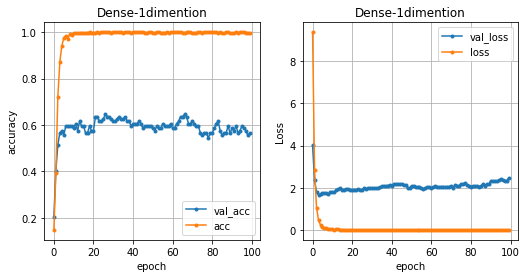

In [71]:
history = model.history
epoch = history.epoch
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
acc = history.history['acc']
loss = history.history['loss']

fig= plt.figure(figsize=(8.5, 4))
ax, ax_ = fig.add_subplot(121), fig.add_subplot(122)

# ax.plot([epoch[0], epoch[-1]] , [1, 1], 'k', ls='dashed', alpha=0.5)
ax.plot(epoch, val_acc, '.-', label='val_acc')
ax.plot(epoch, acc, '.-', label='acc')
ax_.plot(epoch, val_loss, '.-', label='val_loss')
ax_.plot(epoch, loss, '.-', label='loss')

ax.grid()
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Dense-1dimention')

ax_.grid()
ax_.legend()
ax_.set_xlabel('epoch')
ax_.set_ylabel('Loss')
ax_.set_title('Dense-1dimention')

### predict

In [76]:
x_test_r = np.zeros((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_test_r[:, :, :, 0] = x_test
t_test = model.predict(x_test_r)
x_test_r.shape
t_test.shape

(594, 99)

---
id = 1400
label = Eucalyptus_Glaucescens


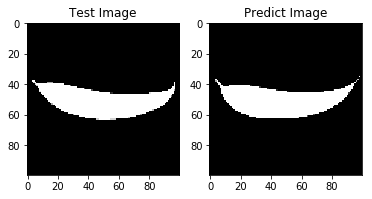

---
id = 1151
label = Quercus_Pyrenaica


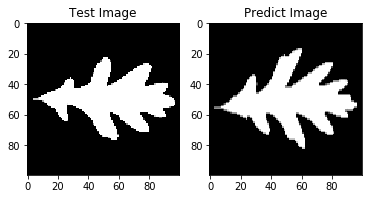

---
id = 950
label = Acer_Mono


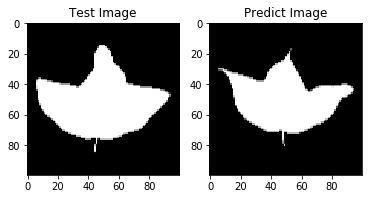

---
id = 1371
label = Quercus_Brantii


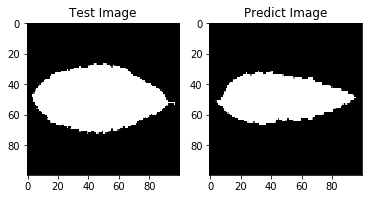

---
id = 343
label = Quercus_Crassipes


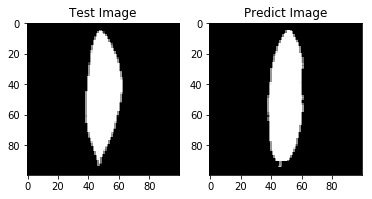

---
id = 1252
label = Quercus_Ellipsoidalis


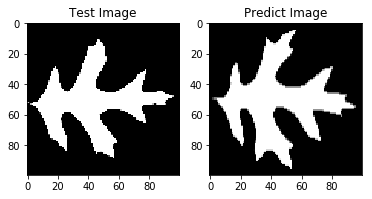

---
id = 391
label = Crataegus_Monogyna


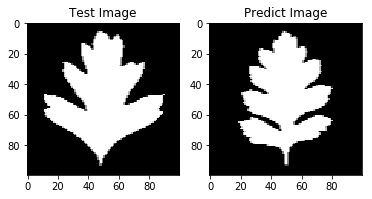

---
id = 1297
label = Quercus_Coccinea


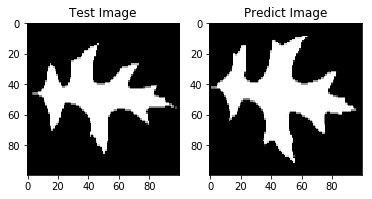

---
id = 1044
label = Prunus_X_Shmittii


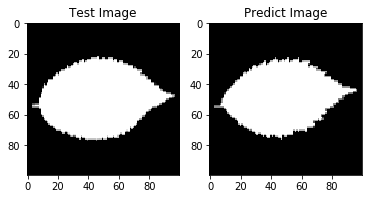

---
id = 1012
label = Quercus_Ilex


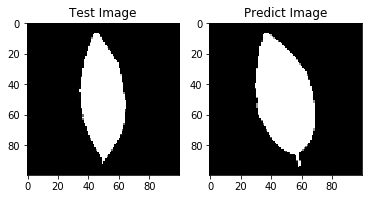

In [74]:
def show_png(label=''):
    x_id = train['id'].values
    x_species = train['species'].values
    x_classes_idx = np.array([x_id[i] for i, _ in enumerate(x_species) if _ == label])[0]
    img = Image.open('../input/images/{:.0f}.jpg'.format(x_classes_idx))
    
    return img

def predict_png(idx=0):
    t_id_test = test['id'].values
    t_idx = np.argmax(t_test[idx])
    t_label = classes[t_idx]
    t_id = t_id_test[idx]
    img = Image.open('../input/images/{:.0f}.jpg'.format(t_id))
    
    print('id = ' + str(t_id))
    print('label = ' + t_label)
    
    fig = plt.figure()
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)   
    ax1.imshow(resize_img(np.array(img), end_size=100, show=True), 'gray')
    ax1.set_title('Test Image')    
    ax2.imshow(resize_img(np.array(show_png(t_label)), end_size=100, show=True), 'gray')
    ax2.set_title('Predict Image') 
    
    plt.show()

for idx in np.random.choice(594, 10):
    print('---')
    predict_png(idx)

### submission

In [1]:
submission = pd.DataFrame()
submission['id'] = test['id']
for i, label in enumerate(label_species.keys()):
    submission[label] = t_test[:,i]

NameError: name 'pd' is not defined

In [78]:
submission

,id,Acer_Opalus,Pterocarya_Stenoptera,Quercus_Hartwissiana,Tilia_Tomentosa,Quercus_Variabilis,Magnolia_Salicifolia,Quercus_Canariensis,Quercus_Rubra,Quercus_Brantii,...,Quercus_Ellipsoidalis,Quercus_x_Hispanica,Quercus_Shumardii,Quercus_Rhysophylla,Castanea_Sativa,Ulmus_Bergmanniana,Quercus_Nigra,Salix_Intergra,Quercus_Infectoria_sub,Sorbus_Aria
0,4,4.065658e-14,1.960964e-10,6.602365e-13,3.071322e-09,5.885431e-12,3.760426e-11,4.056583e-12,4.328740e-09,1.046116e-08,...,1.833618e-08,3.141993e-12,3.038012e-10,3.284747e-11,1.394677e-11,1.022080e-10,1.730609e-08,1.044310e-07,4.648056e-13,6.540226e-12
1,7,4.009855e-07,1.241481e-06,7.890604e-06,4.525334e-07,2.563053e-08,1.516109e-06,8.850847e-06,5.228404e-06,2.296915e-04,...,1.725279e-06,5.505525e-08,4.093285e-07,1.664096e-07,7.911861e-06,1.302294e-07,1.993793e-05,4.832345e-07,5.676447e-07,2.200339e-04
2,9,4.238040e-03,1.335743e-01,6.927973e-05,5.004737e-04,9.129034e-02,1.600851e-04,2.803532e-02,1.139082e-02,3.754742e-01,...,5.459872e-05,4.701829e-06,2.518650e-06,1.327562e-04,6.369208e-05,1.583517e-02,1.091906e-04,1.043640e-03,3.501737e-05,1.526380e-05
3,12,7.882408e-06,1.010568e-06,2.302911e-06,6.015668e-05,9.000270e-07,1.383068e-06,8.095212e-05,6.219391e-06,3.633537e-05,...,1.448280e-04,1.971768e-03,1.892314e-07,2.221160e-07,5.350614e-05,9.661089e-08,7.836659e-05,6.646930e-05,9.031387e-07,1.959458e-05
4,13,3.004709e-07,1.310624e-06,1.741250e-06,4.823029e-06,3.128619e-07,3.314469e-09,1.418771e-05,1.715993e-04,1.948993e-07,...,3.343800e-04,5.281534e-10,3.724157e-05,2.855661e-04,1.318440e-06,1.032402e-04,5.332833e-07,8.924118e-08,1.949978e-07,3.580961e-07
5,16,1.955250e-11,5.874357e-11,1.455874e-10,9.999951e-01,5.893365e-12,1.478318e-10,3.668736e-08,8.008829e-07,3.599951e-07,...,5.081314e-10,3.518834e-12,4.905006e-12,1.871020e-06,1.919767e-07,5.288765e-07,3.916206e-10,9.131557e-10,2.285525e-12,5.349453e-13
6,19,2.965871e-06,3.795972e-06,4.489530e-08,9.944112e-01,1.261308e-10,1.860301e-08,3.254541e-07,9.616825e-05,6.527442e-07,...,5.975919e-06,1.173522e-10,1.972166e-10,6.342387e-05,3.849660e-07,7.293384e-05,4.164211e-10,4.338650e-07,8.061091e-11,1.120405e-07
7,23,6.513210e-05,1.091707e-05,4.613567e-04,6.585023e-04,4.092923e-05,3.038321e-05,1.557504e-03,1.122460e-03,1.049214e-05,...,2.422209e-03,1.407600e-02,9.182028e-06,9.270916e-04,1.530740e-03,1.765543e-05,1.124758e-03,4.363839e-05,1.060560e-04,3.924415e-04
8,24,2.320785e-07,1.726322e-06,7.248646e-07,1.859606e-06,5.767799e-07,6.450087e-05,5.422510e-06,1.235073e-05,3.056708e-06,...,2.692594e-05,6.432546e-06,3.608063e-06,5.283056e-07,1.633823e-05,3.834702e-08,7.381160e-07,2.321069e-08,5.499721e-07,2.064377e-05
9,28,1.341743e-12,1.170507e-09,7.820347e-13,3.875416e-09,3.822954e-12,5.726543e-13,3.306192e-10,1.299448e-04,9.998698e-01,...,2.254373e-10,2.310349e-14,1.837266e-13,6.410617e-11,1.206402e-12,1.369835e-13,9.355813e-11,6.831487e-08,9.505524e-14,1.340851e-14


In [79]:
submission.to_csv('./submission_Conv2D-img-1.csv', index=False)